# Brian Sohn, bs3358

In [21]:
import pymc as pm
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
# observations 

b = [1.0, 1.1, 1.06, 0.98, 1.03] # log highest bid
r = [0.4, 0.3, 0.3, 0.2, 0.2] # cost / bid ratio
pp = [0.3, 0.3, 0.1, 0.1, 0.08] # log percentage profit

# 1. Modeling log(highest bid), cost/bid ratio, log(percentage profit)

## 1.1. Modeling log(highest bid)

log(highest bid) ~  $ N(\mu_0, \sigma_0^2) $ <br>
$ \mu_0 $ ~ $ N(1,0.1^2) $ : assuming a normal prior<br>
$ \sigma_0 $ ~ $HN(200)$ : improper prior


In [3]:
bid_model = pm.Model()

with bid_model:
    mu_0 = pm.Normal('mu_0', mu = 1, sigma = 0.1)
    sigma_0 = pm.HalfNormal('sigma_0', sigma = 200)
    b_obs = pm.Normal('b_obs', mu = mu_0, sigma = sigma_0, observed = b)
    bid_posterior = pm.sample(target_accept = 0.95)
    pm.sample_posterior_predictive(bid_posterior,extend_inferencedata=True)

az.summary(bid_posterior)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_0, sigma_0]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 65 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_0,1.029,0.033,0.966,1.096,0.001,0.001,1428.0,1173.0,1.0
sigma_0,0.073,0.041,0.024,0.141,0.001,0.001,1144.0,1452.0,1.0


<AxesSubplot: xlabel='b_obs / b_obs'>

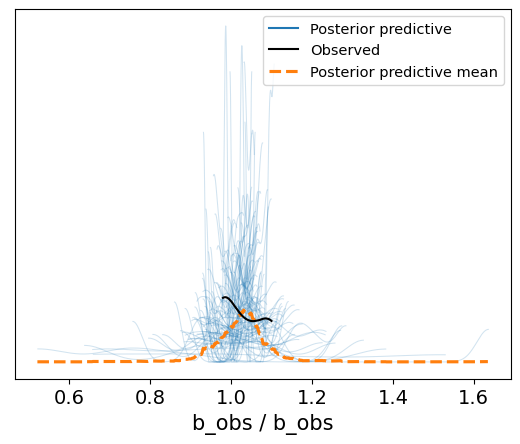

In [6]:
az.plot_ppc(bid_posterior, num_pp_samples=100)

## 1.2. Modeling cost/bid ratio

cost/bid ~ $Beta(\alpha_0, 1)$ <br>
Since $E[cost/bid] = 0.5$, $\frac{E[\alpha_0]}{E[\alpha_0]+1}$ = $\frac{1}{2}$ <br>
Therefore we want $E[\alpha_0] = 1$. <br>
$\alpha_0$ ~ $Exp(1)$

In [7]:
ratio_model = pm.Model()

with ratio_model:
    alpha_0 = pm.Exponential('alpha_0', lam = 1)
    r_obs = pm.Beta('r_obs', alpha = alpha_0, beta = 1, observed = r)
    ratio_posterior = pm.sample(target_accept = 0.95)
    pm.sample_posterior_predictive(ratio_posterior,extend_inferencedata=True)

az.summary(ratio_posterior)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha_0]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 62 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha_0,0.807,0.328,0.23,1.406,0.009,0.007,1329.0,1305.0,1.0


<AxesSubplot: xlabel='r_obs / r_obs'>

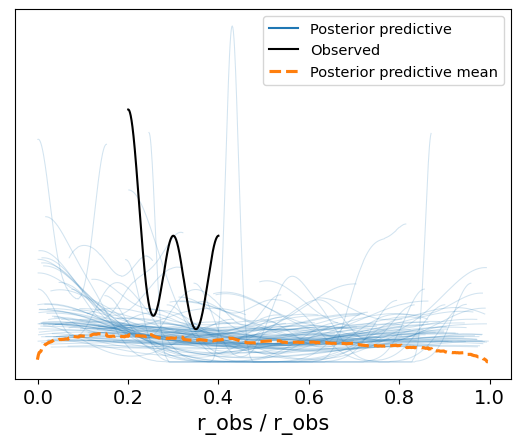

In [8]:
az.plot_ppc(ratio_posterior, num_pp_samples=100)

## 1.3. Modeling log(percentage profit)

log(percentage profit) ~ $N(\mu_1, \sigma_1^2)$ <br>
$ \mu_1 $ ~ $ N(0.2,0.05^2) $ : assuming a normal prior<br>
$ \sigma_1 $ ~ $HN(200)$ : improper prior

In [9]:
percentage_profit_model = pm.Model()

with percentage_profit_model:
    mu_1 = pm.Normal('mu_1', mu = 0.2, sigma = 0.05)
    sigma_1 = pm.HalfNormal('sigma_1', sigma = 200)
    pp_obs = pm.Normal('pp_obs', mu = mu_1, sigma = sigma_1, observed = pp)
    pp_posterior = pm.sample(target_accept = 0.95)
    pm.sample_posterior_predictive(pp_posterior,extend_inferencedata=True)

az.summary(pp_posterior)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_1, sigma_1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 63 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_1,0.191,0.039,0.118,0.265,0.001,0.001,2377.0,1882.0,1.0
sigma_1,0.154,0.099,0.063,0.275,0.003,0.002,2310.0,2038.0,1.0


<AxesSubplot: xlabel='pp_obs / pp_obs'>

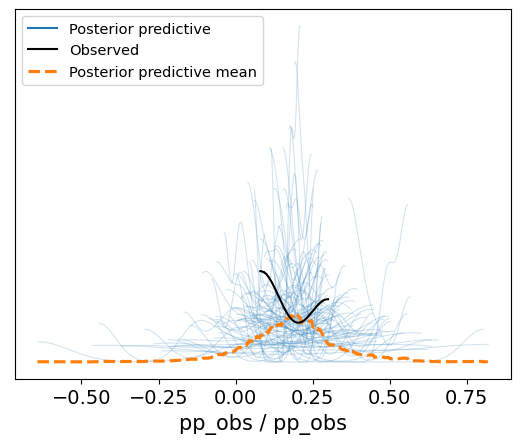

In [14]:
az.plot_ppc(pp_posterior, num_pp_samples=100)

# 2. Finding the optimal bid

## 2.1. Constructing samples for highest bid, cost, sale price

First, we sample data from the posterior predictive of log(highest bid), cost/bid ratio, and log(percentage profit) 

In [15]:
bid_posterior_predictive_samples = np.array(bid_posterior.posterior_predictive.b_obs).flatten()
ratio_posterior_predictive_samples = np.array(ratio_posterior.posterior_predictive.r_obs).flatten()
pp_posterior_predictive_samples = np.array(pp_posterior.posterior_predictive.pp_obs).flatten()

Next, we get samples of highest bid, cost, and sale price from the following facts: <br>
highest bid = $exp(log(highestbid))$ <br>
cost = $highest bid * \frac{cost}{highestbid}$ <br>
sale price = $exp(log(percentageprofit)) * (cost+highestbid)$

In [16]:
highest_bid_samples = np.exp(bid_posterior_predictive_samples)
cost_samples = highest_bid_samples * ratio_posterior_predictive_samples
price_samples = np.exp(pp_posterior_predictive_samples) * (highest_bid_samples + cost_samples)

## 2.2. Finding optimal bid by calculating expected profit for each candidate bid

If my bid > highest bid, profit = $saleprice - (cost + mybid)$ <br>
Else, profit = $-(price-(cost+highestbid))$

In [17]:
xrange = np.arange(1,4.01,0.01) # candidates for my bid
exp_profits = []

for x in xrange:
    profit = np.where(x>highest_bid_samples, price_samples - (cost_samples + x), -(price_samples - (cost_samples+highest_bid_samples)))
    exp_profits.append(np.mean(profit)) # use mean for expected profit



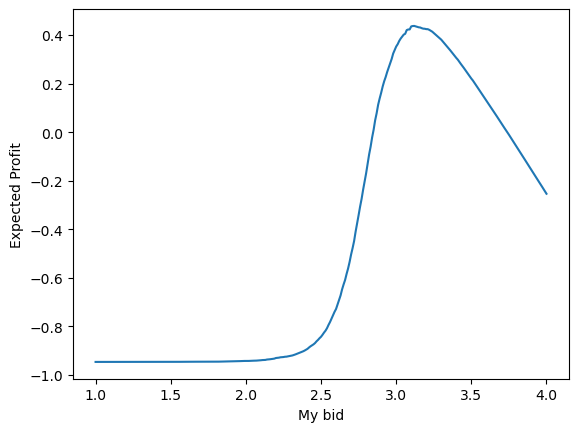

In [18]:
plt.plot(xrange, exp_profits)
plt.xlabel('My bid')
plt.ylabel('Expected Profit')
plt.show()

In [19]:
xrange[np.argmax(exp_profits)]

3.120000000000002

Therefore the optimal bid based on my models would be 3.12 million USD. 

In [23]:
math.log(3.12)

1.1378330018213911

Or in log terms (for comparison with highest bid), it would be 1.14